In [ ]:
# -*- coding: utf-8 -*-
import os
import numpy as np

IQ数据解码

In [208]:

class DualPolData(object): 
    '''
    decode the IQ signal data
    '''
    def __init__(self, filename, station_lon=None, station_lat=None, station_alt=None, debug_model = 0):
        super(DualPolData,self).__init__()
        self.filename = filename
        self.station_lon = station_lon
        self.station_lat = station_lat
        self.station_alt = station_alt
        self.debug_model = debug_model
        self.fid = _prepare_for_read(self.filename)  ##对压缩的文件进行解码
        self._check_dualpol_data()  #check whether the file is Dual-Pol IQ data
        self.header = self._parse_TSHeader()
        self.radial = self._parse_radial()
        self.nrays = len(self.radial)
        print("nrays: ",self.nrays)
        self.azimuth = self.get_azimuth()
        self.elevation = self.get_elevation()
        self.fid.close()

    def _parse_TSHeader(self):
        TSHeader = {}                                                                                                                                                                       
        print(Dual_IQ.TSHeaderBlockSize)
        fixed_buf = self.fid.read(Dual_IQ.TSHeaderBlockSize)  ##读取前面固定头的信息
        TSHeader, size = _unpack_from_buf(fixed_buf, \
                                                              Dual_IQ.TSHeaderPos,
                                                              Dual_IQ.TSHeader)                                                                                      
        return TSHeader
                                                              
    def _parse_radial(self):
        #IQ_length = (channel*binnum+firstbinnum)*2*2
        radial = []
        self.fid.seek(0, 0)
        self.fid.seek(Dual_IQ.TSSweepHeaderPos, 0)
        buf = self.fid.read(Dual_IQ.TSSweepBlockSize, )
        iteration_no = 0
        while len(buf) == Dual_IQ.TSSweepBlockSize: # and iteration_no < 100: 
            iteration_no += 1 
            RadialDict, size = _unpack_from_buf(buf, 0, Dual_IQ.TSSweepHeader())
            #print(RadialDict)
            self.chan = int(RadialDict['chan'])
            self.binnum = int(RadialDict['binnum'])
            #print('bin no.',RadialDict['binnum'])
            self.burstbinnum = int(RadialDict['burstbinnum'])
            self.LengthOfData = ( self.chan * self.binnum+ self.burstbinnum ) * 2 * 2
            if self.LengthOfData > 1:
                RadialDict['Azimuth'] = RadialDict['Azimuth'] / 100.
                RadialDict['Elevation'] = RadialDict['Elevation'] / 100.
            else:
                RadialDict['Azimuth'] = np.nan
                RadialDict['Elevation'] = np.nan
            #print("length",self.LengthOfData)
            RadialDict['fields'] = self._parse_radial_single()
            #RadialDict['H_IQ']=unpack(buf,'uint16',data['d'][-1]['binnum']*2,ptr+128)
            radial.append(RadialDict)
            buf = self.fid.read(Dual_IQ.TSSweepBlockSize)
            if (self.debug_model == 1):
                print(radial[-1])
        return radial
    
    def _parse_radial_single(self):
        '''decode for each radial'''
        radial_var = {}
        Hdata_buf = self.fid.read( self.binnum * 2 *2)
        Hdata_tmp = (np.frombuffer(Hdata_buf, dtype="uint16", offset=0)).astype(int) # <表示字节顺序，小端；U表示Unicode，数据类型，1表示元素位长，数据大小
        #numpy.frombuffer(buffer, dtype=float, count=-1, offset=0)
        #16 bit是2字节
        radial_var['H_I'], radial_var['H_Q'] = IQ_unpack(Hdata_tmp)
        radial_var['Pt_H'] = np.power(radial_var['H_I'],2) + np.power(radial_var['H_Q'],2)

        if self.chan == 2:
            Vdata_buf = self.fid.read( self.binnum * 2 *2 )
            Vdata_tmp = (np.frombuffer(Vdata_buf, dtype="uint16", offset=0)).astype(int)
            radial_var['V_I'], radial_var['V_Q'] = IQ_unpack(Vdata_tmp)
            radial_var['Pt_V'] = np.power(radial_var['V_I'],2) + np.power(radial_var['V_Q'],2)

        Burst_buf = self.fid.read( self.burstbinnum * 2 *2 )
        BurstData_tmp = (np.frombuffer(Burst_buf, dtype="uint16", offset=0)).astype(int)
        
        return radial_var
                                               
    def _check_dualpol_data(self):
        """
        :param fid: file fid
        :return:
        """
        assert self.fid.read(0) in b"34", 'It is not a dual-pol signal!'
        self.fid.seek(0, 0)
        return

    def get_azimuth(self):
        """
        获取每根径向的方位角
        :return:(nRays)
        """
        az = np.array([self.radial[iray]['Azimuth'] for iray in range(self.nrays)])
        az = np.where(az < 0, az + 360, az)
        return az

    def get_elevation(self):
        """
        获取每根径向的仰角
        :return: (nRays)
        """
        return np.array([self.radial[iray]['Elevation'] for iray in range(self.nrays)])
    
def IQ_unpack(data):
    data_=np.empty_like(data,dtype='float32')
    
    for i,v in enumerate(data):
        E=v>>12 #按位右移 >> 第11位符号位在最前面
        S=(v&0x0FFF)>>11
        M=v&0x07FF
        SM=v&0x0FFF
        
        if E!=0:
            M1=np.array(M,dtype='int32')
            if S:
                M1|=0x800
            else:
                M1|=0xfffff000
                
            E=np.array(E,dtype='float32')
            data_[i]=M1*2**(E-25)
        else:
            data_[i]=SM*2**(-24)
    
    return data_[0::2],data_[1::2]

import bz2
import gzip
def _prepare_for_read(filename):
    """
    Return a file like object read for reading.
    Open a file for reading in binary mode with transparent decompression of
    Gzip and BZip2 files.  The resulting file-like object should be closed.
    Parameters
    ----------
    filename : str or file-like object
        Filename or file-like object which will be opened.  File-like objects
        will not be examined for compressed data.
    Returns
    -------
    file_like : file-like object
        File like object from which data can be read.
    """
    # if a file-like object was provided, return
    if hasattr(filename, 'read'):  # file-like object
        return filename
    # look for compressed data by examining the first few bytes
    fh = open(filename, 'rb')
    magic = fh.read(1)
    fh.close()
    if magic.startswith(b'\x1f\x8b'):
        f = gzip.GzipFile(filename, 'rb')
    elif magic.startswith(b'BZh'):
        f = bz2.BZ2File(filename, 'rb')
    else:
        f = open(filename, 'rb') #r:read; b: binary
    return f


定义IQ数据结构

In [56]:
SHORT = 'h'
INT = 'i'
FLOAT = 'f'
CHAR = 's'
class DualFormat(object):

    def __init__(self):
        self.TSHeaderPos = 0
        self.TSSweepHeaderPos = 128+256
        self.TSHeaderBlockSize = 128
        self.TSSweepBlockSize = 128
        self.flag2Product = {1:'H_I', 2:'H_Q', 3:'V_I', 4:'V_Q', 5:'velocity', 6:'reflectivity', 7:'ZDR', 8:'LDR',\
                             9:'CC', 10:'PhiDP', 11:'KDP'}

        self.TSHeader = (
            ('Version', 'B'),       # 1,2: single polarization; 3: dual-pol version; 4: burst signal included
            ('SiteName', '16s'),  
            ('spared1', INT),  
            ('spared2', CHAR),  
            ('pol', 'B'),           # h = 0, v = 1, hv =3
            ('pulsewidth', FLOAT),  # pulse width in microseconds
            ('calibration', FLOAT), # horizaontal calibration reflectivity (dBZ at 1 km)
            ('noise', FLOAT),       # noise level of the system in dBm
            ('freq', FLOAT),        # MHz
            ('firstbin', SHORT),    # first bin range in meter
            ('phasecode', CHAR),
            ('vnoise', FLOAT),      # noise level of v channel
            ('vcalib', FLOAT),      # vertical calibration reflectivity (dBZ at 1 km)
            ('pad', '78s')
        )    

    def TSSweepHeader(self):
        TSSweepHeaderBlock = (
            ('time', '8s'),  # 
            ('clock', INT),  # # 径向数据采集时间除去秒后留下的毫秒数
            ('seqnum', INT),  # 序号，每个体扫径向从1开始计数
            ('latitude', INT),  # 径向数，每个扫描从1开始
            ('longitude', INT),  # 仰角编号，从1开始
            ('height', INT),
            ('Azimuth', SHORT),  # 方位角  in scale of 1/100 degree
            ('Elevation', SHORT),  # 仰角   in scale of 1/100 degree
            ('prf', SHORT),  # 径向数据采集时间 UTC 从19700101 00：00开始 秒
            ('samples', SHORT),  
            ('binnum', SHORT),  # 本径向数据块的长度
            ('reso', SHORT),  # 径向数据
            ('mode', 'B'),  # 保留
            ('state', INT),  # radial state,0 cut_start,1 cut_mid,2 cut_end,3 vol_start,4 vol_end
            ('sploblank', 'B'),  # true if the radial is sector blanking
            ('nextprf', SHORT),  # PRF of next sweep
            ('burstmag', FLOAT),  # magnitude of burst
            ('burstang', FLOAT),  # angle of burst
            ('swpidx', SHORT),  # index of this sweep in the radial
            ('anglereso', SHORT),  # angle (azimuth for ppi ) resolution
            ('chan', 'B'),  # channnel number in this pulse 1 for h only and v only,2 for h+v
            ('length', 'H'),  # for rawiq, internal use
            ('burstbinnum', SHORT), 
            ('pad_reserved', '63s')
        )
        return TSSweepHeaderBlock

Dual_IQ = DualFormat()

import struct
def _structure_size(structure):
    """
    计算structure的字节大小
    eg: struct.calcsize('<iHHb');
    out: 9. int(4)+unsigned short(2*2)+signed char(1) = 9
    """
    return struct.calcsize('<' + ''.join([i[1] for i in structure]))

def _unpack_from_buf(buf, pos, structure):
    '''unpack a structure from buf, the starting position is pos'''
    size = _structure_size(structure)
    return _unpack_structure(buf[pos:pos + size], structure), size

def _unpack_structure(string, structure):
    '''unpack a structure from a string'''
    fmt = '<' + ''.join([i[1] for i in structure])
    lst = struct.unpack(fmt, string)
    #struct.unpack(format, buffer): 根据格式字符串 format 从缓冲区 buffer 解包（假定是由 pack(format, ...) 打包）。 
    return dict(zip([i[0] for i in structure], lst))

实例1
1. read

In [160]:
def read_DualPol(filename, station_lon=None, station_lat=None, station_alt=None):
    """
    :param filename:  radar basedata filename
    :param station_lon:  radar station longitude //units: degree east
    :param station_lat:  radar station latitude //units:degree north
    :param station_alt:  radar station altitude //units: meters
    """
    return DualPolData(filename, station_lon, station_lat, station_alt)
file = r'Z9002_20220624_005007_10_CDX.IQ'
PRD = read_DualPol(file)

128
nrays:  23662


<ipython-input-159-e12d9cefc8a8>:98: RuntimeWarning: invalid value encountered in less
  az = np.where(az < 0, az + 360, az)


I & Q, sample = 65, saying that 65 samples in one angle.

直接求平均结果


max Horizontal power = 15.864641, max vertical Power = 0.019767


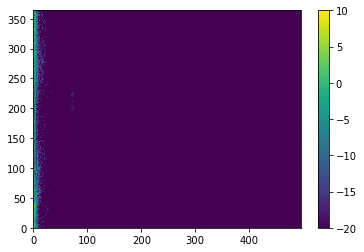

In [351]:
import math
samples = PRD.radial[4]['samples']
mean_az = []
mean_el = []
mean_PtH  = []
mean_PtV  = []
#print( [PRD.radial[iray]['samples'] for iray in range(0,10000,100)] )
Nradial = math.floor(PRD.nrays/samples)
for i in range(0,Nradial):    
    iray = i * samples #+ 2 # 最前面两个radial是空
    assert (PRD.radial[i+3]['samples'] == 65) 
    mean_az.append( np.nanmean( PRD.azimuth[iray:iray+samples] ))
    mean_el.append( np.nanmean( PRD.elevation[iray:iray+samples] ))
    mean_PtH.append( np.array([PRD.radial[j]['fields']['Pt_H'] for j in range(iray,iray+samples) if PRD.radial[j]['chan'] == 2]).mean(axis=0) )
    mean_PtV.append( np.array([PRD.radial[j]['fields']['Pt_V'] for j in range(iray,iray+samples) if PRD.radial[j]['chan'] == 2]).mean(axis=0) )

# transfer list to array
mean_PtH_ar =  np.zeros((len(mean_PtH),len(np.array(mean_PtH)[1])),dtype=float)
mean_PtV_ar =  np.zeros((len(mean_PtV),len(np.array(mean_PtV)[1])),dtype=float)
for i in range(len(mean_PtH)):
    mean_PtH_ar[i][:] = mean_PtH[i][:]
    mean_PtV_ar[i][:] = mean_PtV[i][:]

print("max Horizontal power = %f, max vertical Power = %f" %(np.nanmax(mean_PtH_ar),np.mean(mean_PtH_ar)))
#mean_PtH = np.where(mean_PtH < 1, np.nan, mean_PtH)
plt.pcolormesh(10 * np.log10(mean_PtH_ar) , vmin = -20, vmax = 10,  shading='auto')
plt.colorbar()


相参积累
FFT

In [367]:
#print( [PRD.radial[iray]['state'] for iray in range(0,10000)] )
print( PRD.radial[66]['fields']['H_I'] )

aa = np.array([ PRD.radial[iray]['fields']['H_I'] for iray in range(2,66) ])
bb = np.array([ complex( PRD.radial[iray]['fields']['H_I'], PRD.radial[iray]['fields']['H_Q']) for iray in range(2,66) ])
#print(aa.shape)
#bb = np.fft.fft(aa)

plt.imshow(aa) 

[ 2.00000000e+00  1.27343750e+00 -3.79562378e-03 -4.49584961e-01
  2.26501465e-01  2.29492188e-02  9.88525391e-01  4.13055420e-02
  4.39697266e-01  2.86560059e-02  3.98864746e-02  1.18072510e-01
  1.02172852e-01 -4.72259521e-02 -2.82478333e-03  1.25198364e-02
  8.78906250e-03  1.26686096e-02 -1.21154785e-02  5.32989502e-02
 -1.79748535e-02 -1.19750977e-01  1.44863129e-03 -3.21960449e-02
  1.52778625e-02 -6.89268112e-04  6.28829002e-05 -5.67626953e-02
  2.11791992e-02  3.41186523e-02  1.50451660e-02  7.96318054e-04
 -1.80740356e-02  3.10821533e-02 -3.46946716e-03  2.05841064e-02
 -2.99263000e-03 -7.06863403e-03 -1.41372681e-02  1.41983032e-02
 -1.14250183e-02 -8.13674927e-03  8.94546509e-03 -1.16462708e-02
  3.00521851e-02  3.11584473e-02  1.72567368e-03 -4.74357605e-03
 -2.26783752e-03 -3.36265564e-03 -1.53923035e-03 -1.24626160e-02
 -1.76620483e-02  6.74819946e-03  6.45256042e-03  7.33184814e-03
  1.98650360e-03 -3.08990479e-02 -8.10241699e-03  1.89819336e-02
 -3.12194824e-02  1.52091

TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
#ToLevel2Data:
""" lamda = 5.36/100
Pt = 
tao = 0.5 e6
theta= """

noise  = PRD.header['noise'] # -81
vcalib = PRD.header['vcalib']
hcalib = PRD.header['calibration']
print(hcalib)
N = (noise/10)*0.016*50
SNR_H = np.zeros((len(mean_PtH),len(np.array(mean_PtH)[1])),dtype=float)
SNR_V = np.zeros((len(mean_PtV),len(np.array(mean_PtV)[1])),dtype=float)

for i in range(len(mean_PtH)):
    SNR_H[i][:] = (mean_PtH[i][:]-N)/N 
    SNR_V[i][:] = (mean_PtV[i][:]-N)/N 
SNR_H = np.where(SNR_H < 3, np.nan, SNR_H)
SNR_V = np.where(SNR_V < 3, np.nan, SNR_V)

print(np.nanmax(SNR_H))



R = np.arange(1,SNR_H.shape[1]+1)*500
R = np.stack( [R] *  SNR_H.shape[0] ).reshape(SNR_H.shape) # [] is needed, or it will not do the stack. 
dBZ_H = 10 * np.log10(SNR_H) + hcalib  + 20*np.log10(R) + 0.016 * R
dBZ_V = 10 * np.log10(SNR_V) + vcalib  + 20*np.log10(R) + 0.016 * R
dBZ_H = np.where(dBZ_H == 0.0, np.nan , dBZ_H)
np.nanmax(dBZ_H)
#plt.pcolormesh(dBZ_H)



In [ ]:

radarX = np.zeros(dBZ_H.shape)
radarY = np.zeros(dBZ_H.shape)

Bin_length = 500
for i_az in np.arange(0, dBZ_H.shape[0]): #azimuth comes from east, the direction is counterclockwise
    for i_bin in np.arange(0, dBZ_H.shape[1]):
        #i_az_valied = int(AngleToValid(i_az))
        #R_ac = np.array([( i_bin -1 ) * Bin_length, i_bin * Bin_length])
        #Az_ac = np.array([ i_az - Beam_Width/2, i_az + Beam_Width/2])
        #xy_center = np.array( i_bin * Bin_length * [ np.cos( i_az * math.pi / 180), np.sin( i_az * math.pi / 180) ])
        #x0 = R_ac * np.cos( Az_ac * math.pi / 180)
        x = i_bin * Bin_length * np.sin(np.deg2rad(i_az))
        y = i_bin * Bin_length * np.cos(np.deg2rad(i_az))
        #radarX.append(x)
        #radarY.append(y)
        radarX[i_az, i_bin]  = x
        radarY[i_az, i_bin]  = y

fig = plt.figure(figsize=(12,10))#否则会画出很多蓝色

ax = fig.add_subplot(111)

dBZ_H = np.where(dBZ_H == 0.0, np.nan , dBZ_H)

pc = ax.pcolormesh( radarX/1000, radarY/1000, dBZ_H, shading='auto')

In [271]:
def plot_ppi(self, ax, sweep_num, field_name, min_max=None, cmap_bins=None, cbar=True,
                 orientation="vertical",cbar_ticks=None, cbar_ticklabels=None, clabel=None, **kwargs):
        """
        :param ax: axes.Axes object or array of Axes objects., eg: fig, ax = plt.subplots
        :param sweep_num: The sweep_num volume scan to draw, from 0 start!
        :param field_name: field dict to select data, eg: "dBZ" "V"
        :param cmap: str or Colormap, optional, A Colormap instance or registered colormap name. to see cm.py!
        :param min_max: The colorbar range(vmin, vmax). If None, suitable min/max values are automatically chosen by min max of data!
        :param cmap_bins: bins of colormaps
        :param cbar: if True, plot with colorbar, else not!
        :param orientation: vertical or horizontal, if cbar is True , this is vaild!, colorbar oriention!
        :param cbar_ticks: Set the locations of the tick marks from sequence ticks
        :param cbar_ticklabels: Set the text values of the tick labels.
        :param kwargs: other arguments for pcolormesh!
        :return:
        """
        assert isinstance(ax, matplotlib.axes._axes.Axes), "axes should be matplotlib axes not cartopy axes!"
        if min_max is not None:
            vmin, vmax = min_max
        ax.set_aspect("equal")

        radar_data = self.Radar.fields[field_name]
        x, y = radar_data.x, radar_data.y
        cmaps = plt.get_cmap(cmap)
        levels = MaxNLocator(nbins=cmap_bins).tick_values(vmin, vmax)
        norm = BoundaryNorm(levels, ncolors=cmaps.N, clip=True)
        gci = ax.pcolormesh(x / 1000., y / 1000., radar_data, cmap=cmaps, \
                            zorder=0, norm=norm, shading='auto', **kwargs)

        if cbar:
            cb=plt.colorbar(mappable=gci, ax=ax, orientation=orientation)
            if cbar_ticks is None:
                ticks = levels
            else:
                ticks = cbar_ticks
            cb.set_ticks(ticks)

        if cbar_ticklabels is not None:
            if orientation == "vertical":
                cb.ax.set_yticklabels(cbar_ticklabels)
            else:
                cb.ax.set_xticklabels(cbar_ticklabels)

        if clabel is not None:
            cb.set_label(clabel)
        return gci


364.03076923076924

In [23]:
pol = struct.unpack('B',b'\x06')
print(pol, type(pol))
print(np.frombuffer(b'\x06','uint8',1,0))

(6,) <class 'tuple'>
[6]


In [48]:
structure = 'iHHb'
fmt = '<' + ''.join([i for i in structure])
print(fmt)
lst = struct.unpack(fmt, b'\x14\x00\x00\x00\x90\x01\x00\x00\x00')
print(list(zip([i for i in structure])))
dict(zip([i for i in structure], lst)) #dict 没有重复元素

<iHHb
[('i',), ('H',), ('H',), ('b',)]


{'i': 20, 'H': 0, 'b': 0}

In [67]:
#test
TSHeader = ( ('time', CHAR),  # 径向数据状态
            ('clock', INT),  # 消隐标志  0正常 1消隐
            ('seqnum', INT),  # 序号，每个体扫径向从1开始计数
            ('latitude', INT),  # 径向数，每个扫描从1开始
            ('longitude', INT),  # 仰角编号，从1开始
            ('height', INT),
            ('Azimuth', SHORT),  # 方位角  degree
            ('Elevation', SHORT),  # 仰角   degree
            ('prf', SHORT),  # 径向数据采集时间 UTC 从19700101 00：00开始 秒
            ('samples', SHORT),  # 径向数据采集时间除去秒后留下的毫秒数
            ('binnum', SHORT),  # 本径向数据块的长度
            ('reso', SHORT),  # 径向数据类别数量
            ('mode', CHAR),  # 保留
            ('state', INT),  # radial state,0 cut_start,1 cut_mid,2 cut_end,3 vol_start,4 vol_end
            ('sploblank', CHAR),  # true if the radial is sector blanking
            ('nextprf', SHORT),  # PRF of next sweep
            ('burstmag', FLOAT),  # magnitude of burst
            ('burstang', FLOAT),  # angle of burst
            ('swpidx', SHORT),  # index of this sweep in the radial
            ('anglereso', SHORT),  # angle (azimuth for ppi ) resolution
            ('chan', CHAR),  # channnel number in this pulse 1 for h only and v only,2 for h+v
            ('length', 'H'),  # for rawiq, internal use
            ('burstbinnum', SHORT), 
            ('pad_reserved', '63s')
        )
fmt = '<' + ''.join([i[1] for i in TSHeader])
print(fmt)
struct.calcsize(fmt)

<siiiiihhhhhhsishffhhsHh63s


121

In [369]:
1/1181 * 3*100000 /2 /496

0.2560705798803638

23662


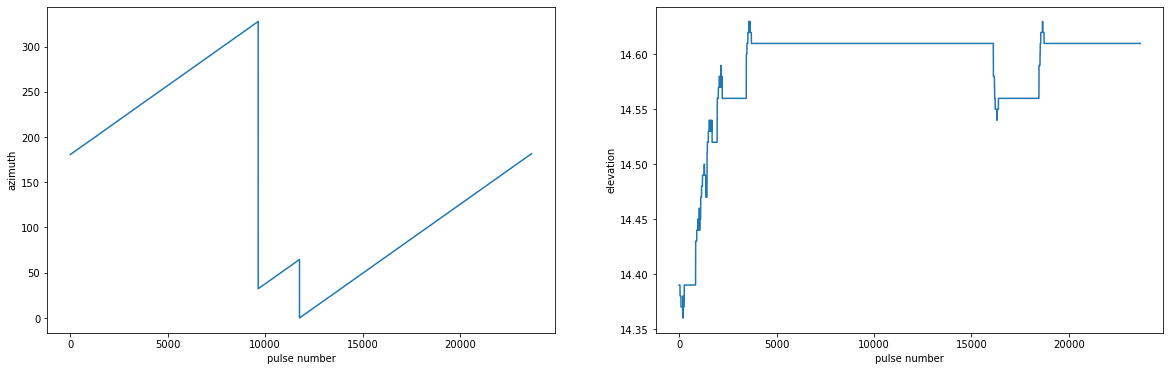

In [166]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121)
ax1.plot(PRD.azimuth)
ax1.set_xlabel('pulse number')
ax1.set_ylabel('azimuth')
ax2 = fig.add_subplot(122)
ax2.plot(PRD.elevation)
ax2.set_xlabel('pulse number')
ax2.set_ylabel('elevation')
PRD.azimuth[1::1000]
print(len(azi))

In [230]:
vcalib = PRD.header['vcalib']
hcalib = PRD.header['calibration']


print("H calibration (dBZ at 1 km) = %6.2f, \nV calibration (dBZ at 1 km) = %6.2f, \nH noise = %6.2f dBm, \nV noise = %6.2f dBm" \
    %(hcalib, vcalib, noise, PRD.header['vnoise']) )
print("PRF = %d Hz, \nbin number in one radial = %d, \nbin length = ? m, \nsamples in one degree azimuth(resolution) = %d" \
    %(PRD.radial[4]['prf'], PRD.radial[4]['binnum'], PRD.radial[4]['samples']))
PRD.radial[4]

H calibration (dBZ at 1 km) =  39.97, 
V calibration (dBZ at 1 km) =   0.00, 
H noise = -81.81 dBm, 
V noise = -81.79 dBm
PRF = 1181 Hz, 
bin number in one radial = 496, 
bin length = ? m, 
samples in one degree azimuth(resolution) = 65


{'time': b'?\n\xb5b\xdc\x92\x05\x00',
 'clock': 270134319,
 'seqnum': 5869681,
 'latitude': 0,
 'longitude': 0,
 'height': 0,
 'Azimuth': 180.73,
 'Elevation': 14.39,
 'prf': 1181,
 'samples': 65,
 'binnum': 496,
 'reso': 0,
 'mode': 1,
 'state': 0,
 'sploblank': 0,
 'nextprf': 1181,
 'burstmag': -0.9331054091453552,
 'burstang': -97.29710388183594,
 'swpidx': 2,
 'anglereso': 0,
 'chan': 2,
 'length': 7968,
 'burstbinnum': 60,
 'pad_reserved': b'<\xef\x19\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00zC\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
 'fields': {'H_I': array([ 2.00000000e+00,  1.08056641e+00, -5.54084778e-04,  6.41601562e-01,
          9.05029297e-01,  3.12805176e-02,  1.11053467e-01,  1.23809814e-01,
          2.29721069e-02,  2.38952637e-01,  2.65121460e-02, -2.68707275e-02,
          3.52935791e-02,  1.12182617e-01, -3.07693481e

In [241]:
np.stack([1,2] * 3).reshape(3,2)

array([[1, 2],
       [1, 2],
       [1, 2]])

In [245]:
np.arange(1,3)*500

array([ 500, 1000])

In [370]:
PRD.header

{'Version': 6,
 'SiteName': b'Z9002\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
 'spared1': 0,
 'spared2': b'\x00',
 'pol': 3,
 'pulsewidth': 0.0,
 'calibration': 39.97019958496094,
 'noise': -81.80718231201172,
 'freq': 2830.0,
 'firstbin': 4,
 'phasecode': b'\x00',
 'vnoise': -81.7934799194336,
 'vcalib': 0.0,
 'pad': b'\x01\x08\x99\xf8Ab\xea\xf1B\x00\x00\x1cB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'}

In [371]:
PRD.radial[4]

{'time': b'?\n\xb5b\xdc\x92\x05\x00',
 'clock': 270134319,
 'seqnum': 5869681,
 'latitude': 0,
 'longitude': 0,
 'height': 0,
 'Azimuth': 180.73,
 'Elevation': 14.39,
 'prf': 1181,
 'samples': 65,
 'binnum': 496,
 'reso': 0,
 'mode': 1,
 'state': 0,
 'sploblank': 0,
 'nextprf': 1181,
 'burstmag': -0.9331054091453552,
 'burstang': -97.29710388183594,
 'swpidx': 2,
 'anglereso': 0,
 'chan': 2,
 'length': 7968,
 'burstbinnum': 60,
 'pad_reserved': b'<\xef\x19\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00zC\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
 'fields': {'H_I': array([ 2.00000000e+00,  1.08056641e+00, -5.54084778e-04,  6.41601562e-01,
          9.05029297e-01,  3.12805176e-02,  1.11053467e-01,  1.23809814e-01,
          2.29721069e-02,  2.38952637e-01,  2.65121460e-02, -2.68707275e-02,
          3.52935791e-02,  1.12182617e-01, -3.07693481e